# Analyzing the Results
Fitting was done in another notebook. This one demonstrates a few different ways to visualize & look at the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets
import pandas
import pathlib
import numpy
from matplotlib import cm, pyplot

import pymc3
import arviz
import xarray

import cutisplit
import run_9REA8P

In [3]:
idata = arviz.from_netcdf("9REA8P_result.nc")
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

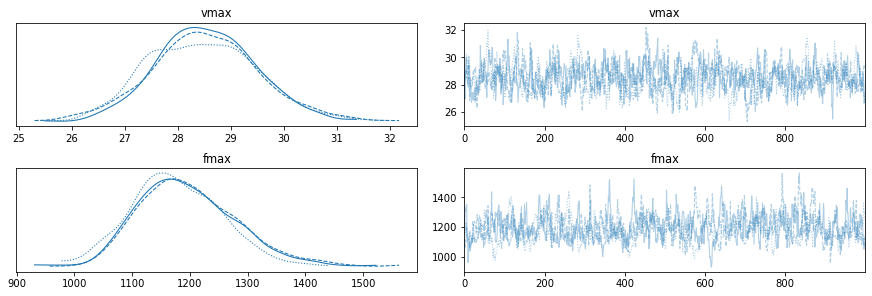

In [4]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=["vmax", "fmax"]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

In [5]:
# The split-GFP assay is more interesting:
# It has nice saturation kinetics and can suffer from fluorescence decay.
cutisplit.plot_sgfp_fit_interactive(idata);

interactive(children=(Dropdown(description='sample_type', options=('reference',), value='reference'), Dropdown…

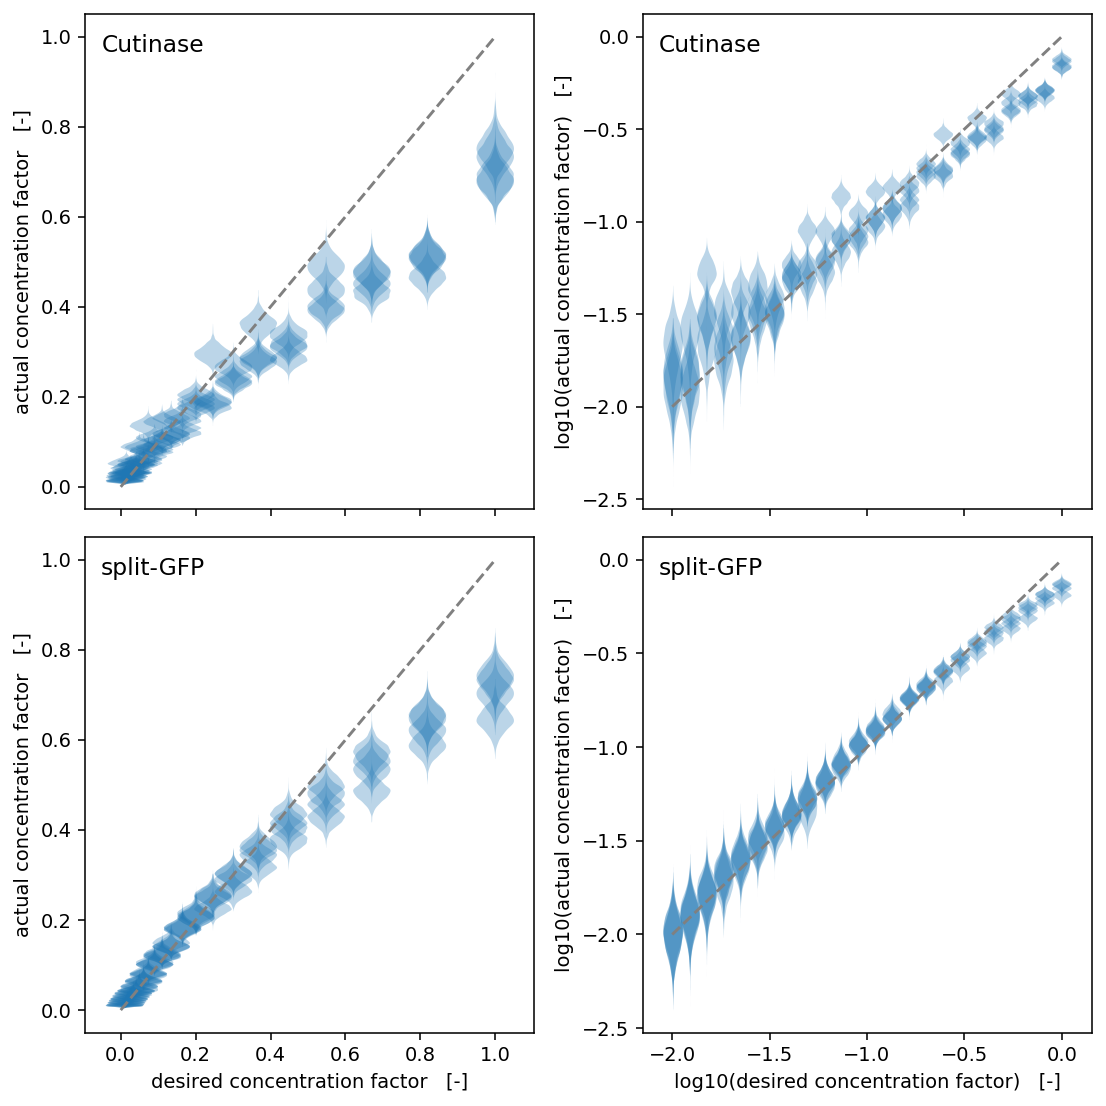

In [6]:
cutisplit.plot_concentration_error(idata);

In [7]:
arviz.summary(idata, var_names=["cf_cutinase_assay", "cf_sgfp_assay"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
cf_cutinase_assay[0],0.686,0.031,0.631,0.744,0.001,0.001,557.0,557.0,556.0,1101.0,1.00
cf_cutinase_assay[1],0.206,0.011,0.186,0.228,0.000,0.000,837.0,836.0,839.0,1498.0,1.00
cf_cutinase_assay[2],0.058,0.006,0.046,0.069,0.000,0.000,2416.0,2400.0,2407.0,2133.0,1.00
cf_cutinase_assay[3],0.680,0.030,0.629,0.739,0.001,0.001,551.0,551.0,551.0,967.0,1.00
cf_cutinase_assay[4],0.176,0.010,0.157,0.195,0.000,0.000,855.0,855.0,852.0,1914.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
cf_sgfp_assay[91],0.049,0.009,0.033,0.065,0.000,0.000,3550.0,3550.0,3347.0,2171.0,1.00
cf_sgfp_assay[92],0.010,0.002,0.006,0.015,0.000,0.000,5024.0,4404.0,5014.0,2216.0,1.00
cf_sgfp_assay[93],0.254,0.015,0.229,0.284,0.001,0.000,751.0,751.0,748.0,1417.0,1.01
cf_sgfp_assay[94],0.053,0.007,0.042,0.067,0.000,0.000,2422.0,2338.0,2601.0,2349.0,1.00


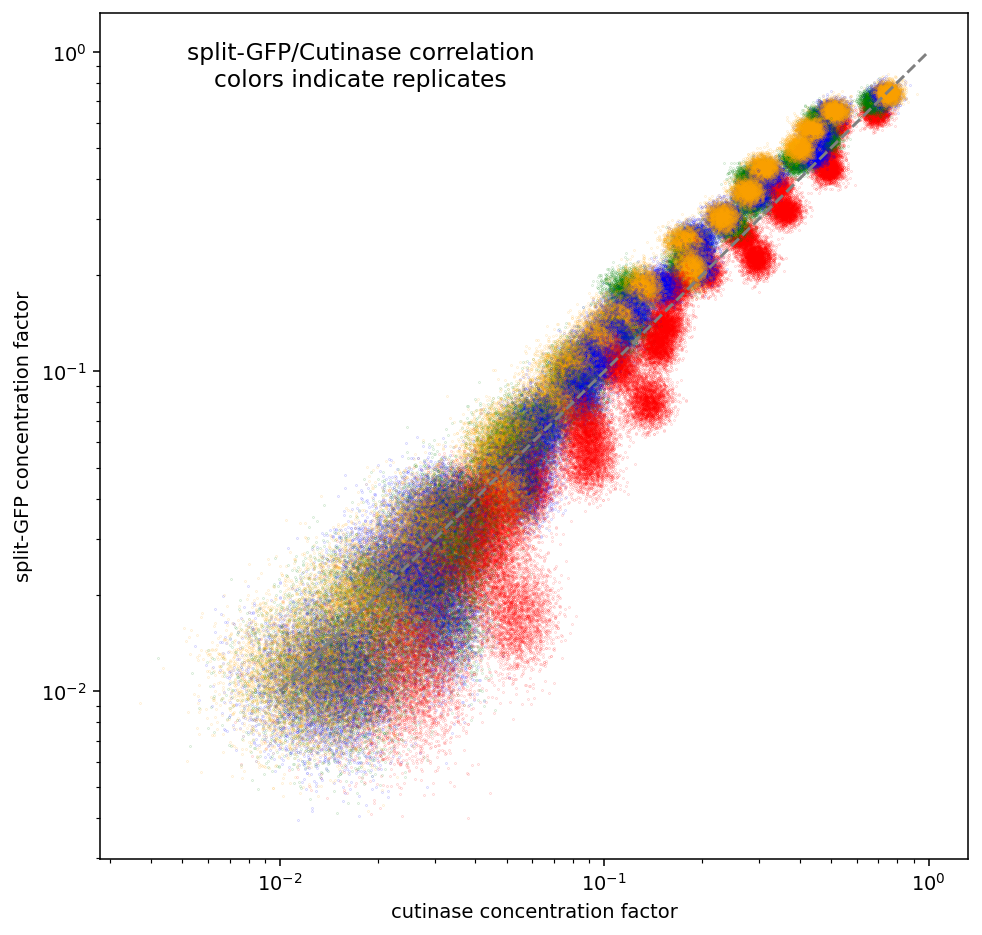

In [8]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
fig, axs = pyplot.subplots(dpi=140, figsize=(8,8))

cf_input = idata.constant_data.cf_input.values
for c, cf in enumerate(numpy.sort(numpy.unique(cf_input))[::-1]):
    iwells = idata.constant_data.input_well[cf_input == cf].values
    awells = cutisplit.replicate_wells_from(iwells)
    for awell, color in zip(awells, ["red", "green", "blue", "orange"]):
        samples_x = posterior.cf_cutinase_assay.sel(assay_well=awell).values
        samples_y = posterior.cf_sgfp_assay.sel(assay_well=awell).values
        axs.scatter(
            samples_x, samples_y,
            marker=".", color=color,
            s=0.02
        )
axs.plot([0.01,1], [0.01,1], color="gray", linestyle="--")
axs.set_xlabel("cutinase concentration factor")
axs.set_ylabel("split-GFP concentration factor")
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_title("split-GFP/Cutinase correlation\ncolors indicate replicates", x=0.3, y=0.9)
# red     original input  e.g. A01
# green   copied input    e.g. A04
# blue    copy of red     e.g. A07
# orange  copy of green   e.g. A10
pyplot.show()